Here is a new notebook incorporating some recent feedback from Dr. B on this. 

In [1]:
# imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, welch, freqz, sosfreqz, filtfilt, lfilter
from scipy.fft import rfft, rfftfreq, irfft
from typing import List, Tuple

In [2]:
# uncomment to viz whole thing
# emotion_subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] # note subj. 22 is missing
# cue_subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# comment out to do more than a few. just a handful for testing the notebook
emotion_subj_list = ['01', '02', '03', '04']
frolich_subj_list = ['01', '02', '03', '04']

In [3]:
def make_windows_from_signal(signal, window_length):
    if signal.ndim == 1 or np.min(signal.shape)==1:
        segment_length = len(signal)
    else:
        n_channels, segment_length = signal.shape
    num_windows = segment_length // window_length
    trunc_signal_size = num_windows * window_length
    if signal.ndim == 1 or np.min(signal.shape)==1:
        windows = signal[:int(trunc_signal_size)].reshape((-1, window_length))
    else:
        windows = signal[:,:int(trunc_signal_size)].reshape((-1, window_length))
    return windows


def make_psds(windows, fs=1, return_freq=False, nfft=None):
    window_length = windows.shape[1]
    if nfft is None:
        nfft = window_length
    if return_freq:
        T = 1 / fs
        return rfftfreq(nfft, T), np.abs(rfft(windows, axis=1, n=nfft)) ** 2
    else:
        return np.abs(rfft(windows, axis=1, n=nfft)) ** 2


def make_cmm_filters(f_targets, f_sources):
    freq_response_magnitudes = np.zeros_like(f_sources)
    f_js_12 = np.sqrt(f_targets)
    for i in range(len(f_sources)):
        f_i_12 = np.sqrt(f_sources[i])
        j_star_i = np.argmin(np.sum((f_js_12 - f_i_12) ** 2, axis=1))
        freq_response_magnitudes[i] = f_js_12[j_star_i] / f_i_12
    return freq_response_magnitudes


def spectral_filtering(x, freq_response_magnitude, type='lfilter', pad_frac=0.5):
    # Assume x is 2D where first dimension is channels/ICs and second is time
    pad_x = np.zeros_like(x)[:, :int(x.shape[1] * pad_frac)]
    padded_x = np.hstack((pad_x, x))
    if type=='filtfilt':
        b = irfft(np.sqrt(freq_response_magnitude))  # take square root for filtfilt
        filtered_x = filtfilt(b, 1, padded_x, axis=1)[:, pad_x.shape[1]:]
    else:
        b = irfft(freq_response_magnitude)
        filtered_x = lfilter(b, 1, padded_x, axis=1)[:, pad_x.shape[1]:]
    return filtered_x


def cmm_filter_signals_to_signals(source_signals, target_signals, window_length, pad_frac=0, filtering_type='filtfilt'):
    # Assume source_signals/target_signals are list of 2D signals where first dimension is channels/ICs and second is time
    source_psds = [np.mean(make_psds(make_windows_from_signal(s, window_length)),axis=0) for s in source_signals]
    target_psds = [np.mean(make_psds(make_windows_from_signal(s, window_length)), axis=0) for s in target_signals]
    cmm_freq_response_magnitudes = make_cmm_filters(target_psds, source_psds)
    source_signals_filtered = [spectral_filtering(s, f, filtering_type, pad_frac)
                               for s, f in zip(source_signals, cmm_freq_response_magnitudes)]
    return source_signals_filtered

In [ ]:
# plotting and util functions



In [4]:
# load data
emotion_filepath = Path('../data/emotion_256/raw_data_and_IC_labels')
frolich_filepath = Path('../data/frolich_256/frolich_extract_256_hz')

emotion_data = []
for subj in emotion_subj_list:
    emotion_data.append(loadmat(emotion_filepath / f'subj-{subj}.mat')['data'])

frolich_data = []
for subj in frolich_subj_list:
    frolich_data.append(loadmat(frolich_filepath / f'frolich_extract_{subj}_256_hz.mat')['X'])

In [5]:
# compute all filters

window_length = 2**10 # just try for now, can nail down better window length later

frolich_data_filtered = cmm_filter_signals_to_signals(frolich_data, emotion_data, window_length)

In [ ]:
# filter data

In [13]:
# plot results

def plot_frolich_data(frolich_data, fs=256, window_length=256, plot_type='all',
                      n_subjects=None, n_channels=None, time_segment=None):
    """
    Plot Fröhlich data in various ways.    Parameters
    ----------
    frolich_data : list of numpy.ndarray
        List of Fröhlich data arrays, each with shape (n_channels, n_samples)
    fs : float, optional
        Sampling frequency in Hz, by default 256
    window_length : int, optional
        Window length for PSD computation, by default 256
    plot_type : str, optional
        Type of plot to generate ('time', 'psd', 'spectrogram', 'all'), by default 'all'
    n_subjects : int, optional
        Number of subjects to plot, by default None (all subjects)
    n_channels : int, optional
        Number of channels to plot per subject, by default None (all channels)
    time_segment : tuple, optional
        Time segment to plot in seconds (start, end), by default None (plots middle 5 seconds)    Returns
    -------
    None
        Displays the plots
    """
    if n_subjects is None:
        n_subjects = len(frolich_data)
    else:
        n_subjects = min(n_subjects, len(frolich_data))    # Determine which plots to generate
    plot_time = plot_type in ['time', 'all']
    plot_psd = plot_type in ['psd', 'all']
    plot_spectrogram = plot_type in ['spectrogram', 'all']    # Time domain plots
    if plot_time:
        plt.figure(figsize=(15, n_subjects * 3))
        plt.suptitle('Fröhlich Data - Time Domain', fontsize=16)
        for i in range(n_subjects):
            data = frolich_data[i]
            if n_channels is None:
                channels_to_plot = min(5, data.shape[0])  # Plot at most 5 channels
            else:
                channels_to_plot = min(n_channels, data.shape[0])            # Determine time segment to plot
            if time_segment is None:
                # Plot middle 5 seconds by default
                middle_idx = data.shape[1] // 2
                start_idx = middle_idx - int(2.5 * fs)
                end_idx = middle_idx + int(2.5 * fs)
                start_idx = max(0, start_idx)
                end_idx = min(data.shape[1], end_idx)
            else:
                start_idx = int(time_segment[0] * fs)
                end_idx = int(time_segment[1] * fs)
                start_idx = max(0, start_idx)
                end_idx = min(data.shape[1], end_idx)

            time_vector = np.arange(start_idx, end_idx) / fs
            plt.subplot(n_subjects, 1, i+1)
            for j in range(channels_to_plot):
                plt.plot(time_vector, data[j, start_idx:end_idx],
                         label=f'Channel {j+1}' if channels_to_plot <= 5 else None)
            if channels_to_plot <= 5:
                plt.legend(loc='upper right')
            plt.title(f'Subject {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()    # PSD plots
    if plot_psd:
        plt.figure(figsize=(15, n_subjects * 3))
        plt.suptitle('Fröhlich Data - Power Spectral Density', fontsize=16)

        for i in range(n_subjects):
            data = frolich_data[i]
            if n_channels is None:
                channels_to_plot = min(5, data.shape[0])
            else:
                channels_to_plot = min(n_channels, data.shape[0])

            plt.subplot(n_subjects, 1, i+1)            # Compute PSD using Dr. B's approach

            windows = make_windows_from_signal(data[:channels_to_plot], window_length)
            psds = make_psds(windows, fs=fs, return_freq=True)

            if isinstance(psds, tuple):  # If return_freq=True
                freqs, psd_values = psds
                for j in range(channels_to_plot):
                    plt.plot(freqs, 10 * np.log10(psd_values[j].mean(axis=0)),
                             label=f'Channel {j+1}' if channels_to_plot <= 5 else None)            # Also plot the average across channels
            if channels_to_plot > 1:
                avg_psd = np.mean([10 * np.log10(psd_values[j].mean(axis=0)) for j in range(channels_to_plot)], axis=0)
                plt.plot(freqs, avg_psd, 'k--', linewidth=2, label='Average')

            if channels_to_plot <= 5 or channels_to_plot > 1:
                plt.legend(loc='upper right')

            plt.title(f'Subject {i+1}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power Spectral Density (dB/Hz)')
            plt.xlim(0, fs/2)
            plt.grid(True, alpha=0.3)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()    # Spectrogram plots
    if plot_spectrogram:
        from scipy.signal import spectrogram
        plt.figure(figsize=(15, n_subjects * 3))
        plt.suptitle('Fröhlich Data - Spectrogram', fontsize=16)

        for i in range(n_subjects):
            data = frolich_data[i]            # For spectrograms, just plot one channel (average if multiple)
            if data.shape[0] > 1:
                data_to_plot = np.mean(data, axis=0)
            else:
                data_to_plot = data[0]

            plt.subplot(n_subjects, 1, i+1)            # Compute spectrogram
            f, t, Sxx = spectrogram(data_to_plot, fs=fs, nperseg=window_length, noverlap=window_length//2)            # Plot spectrogram
            plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
            plt.colorbar(label='Power/Frequency (dB/Hz)')

            plt.title(f'Subject {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.ylim(0, fs/2)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()    # Summary statistics
    print("Fröhlich Data Summary:")
    print(f"Number of subjects: {len(frolich_data)}")

    for i, data in enumerate(frolich_data[:n_subjects]):
        print(f"\nSubject {i+1}:")
        print(f"  Shape: {data.shape}")
        print(f"  Channels: {data.shape[0]}")
        print(f"  Samples: {data.shape[1]}")
        print(f"  Duration: {data.shape[1]/fs:.2f} seconds")
        print(f"  Min value: {np.min(data):.4f}")
        print(f"  Max value: {np.max(data):.4f}")
        print(f"  Mean value: {np.mean(data):.4f}")
        print(f"  Std deviation: {np.std(data):.4f}")

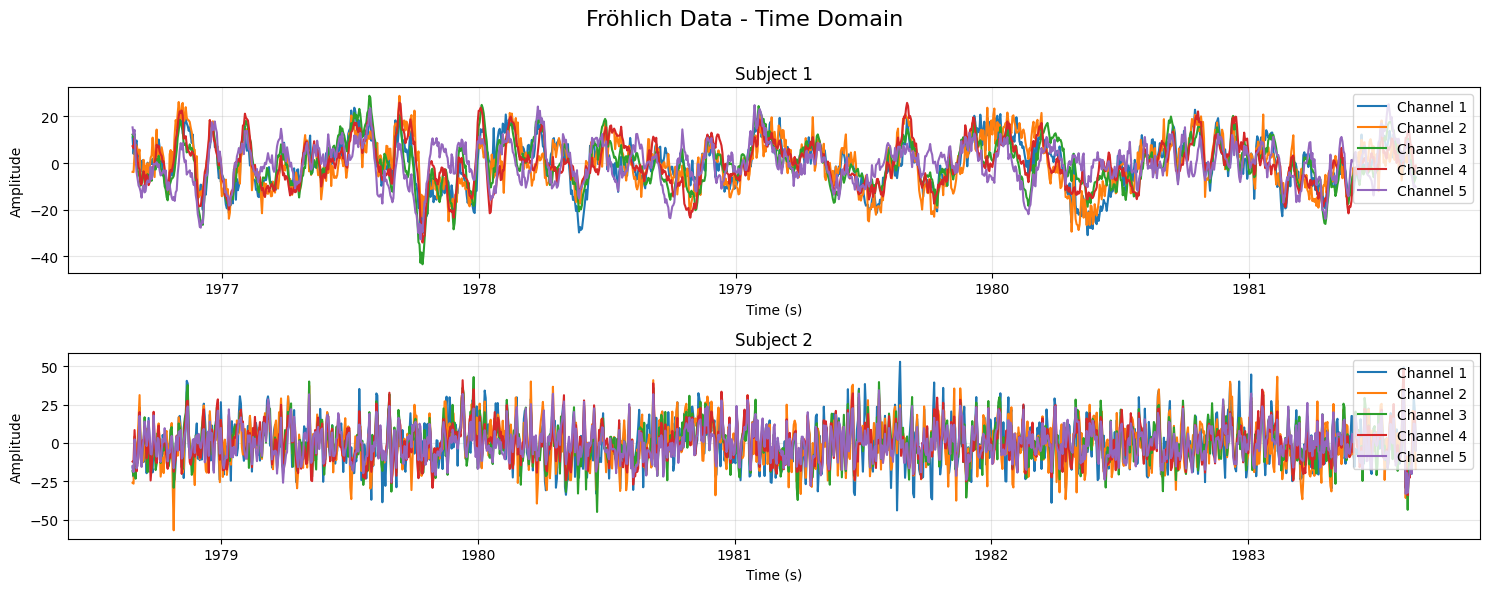

Fröhlich Data Summary:
Number of subjects: 4

Subject 1:
  Shape: (64, 1013327)
  Channels: 64
  Samples: 1013327
  Duration: 3958.31 seconds
  Min value: -319.0403
  Max value: 235.5844
  Mean value: 0.0430
  Std deviation: 9.4299

Subject 2:
  Shape: (64, 1014353)
  Channels: 64
  Samples: 1014353
  Duration: 3962.32 seconds
  Min value: -914.3563
  Max value: 1056.4807
  Mean value: 0.0320
  Std deviation: 12.7576


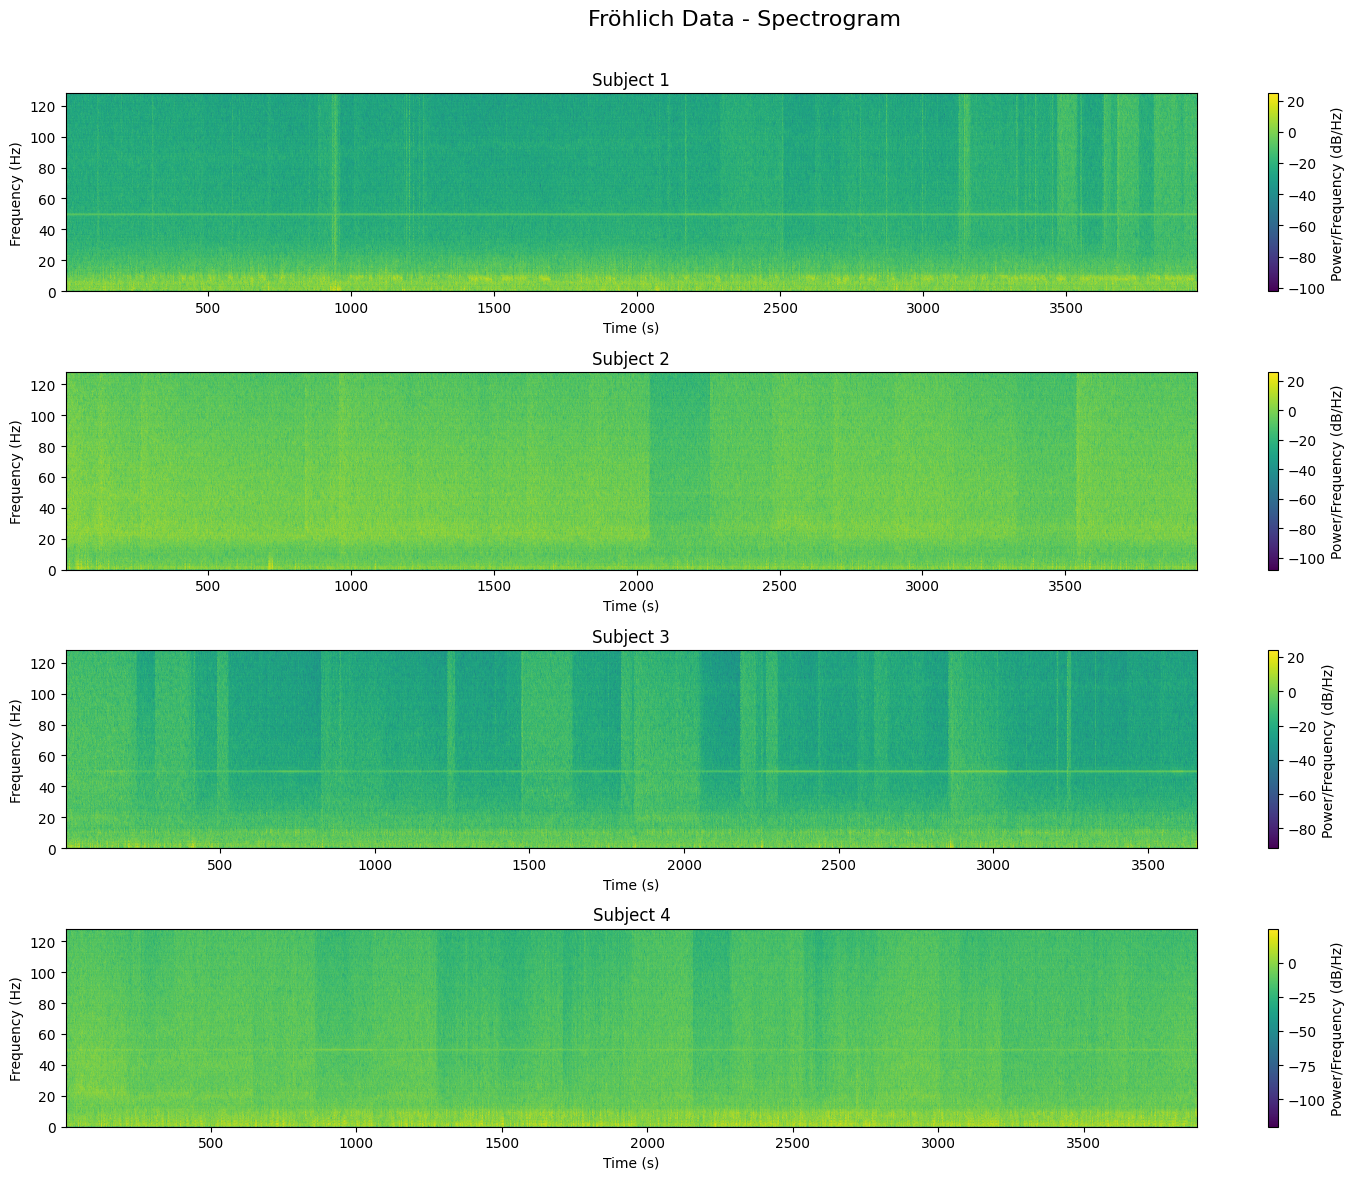

Fröhlich Data Summary:
Number of subjects: 4

Subject 1:
  Shape: (64, 1013327)
  Channels: 64
  Samples: 1013327
  Duration: 3958.31 seconds
  Min value: -319.0403
  Max value: 235.5844
  Mean value: 0.0430
  Std deviation: 9.4299

Subject 2:
  Shape: (64, 1014353)
  Channels: 64
  Samples: 1014353
  Duration: 3962.32 seconds
  Min value: -914.3563
  Max value: 1056.4807
  Mean value: 0.0320
  Std deviation: 12.7576

Subject 3:
  Shape: (64, 936920)
  Channels: 64
  Samples: 936920
  Duration: 3659.84 seconds
  Min value: -241.7691
  Max value: 242.1944
  Mean value: 0.0373
  Std deviation: 7.7488

Subject 4:
  Shape: (64, 996141)
  Channels: 64
  Samples: 996141
  Duration: 3891.18 seconds
  Min value: -463.2944
  Max value: 310.7728
  Mean value: 0.0112
  Std deviation: 13.0173


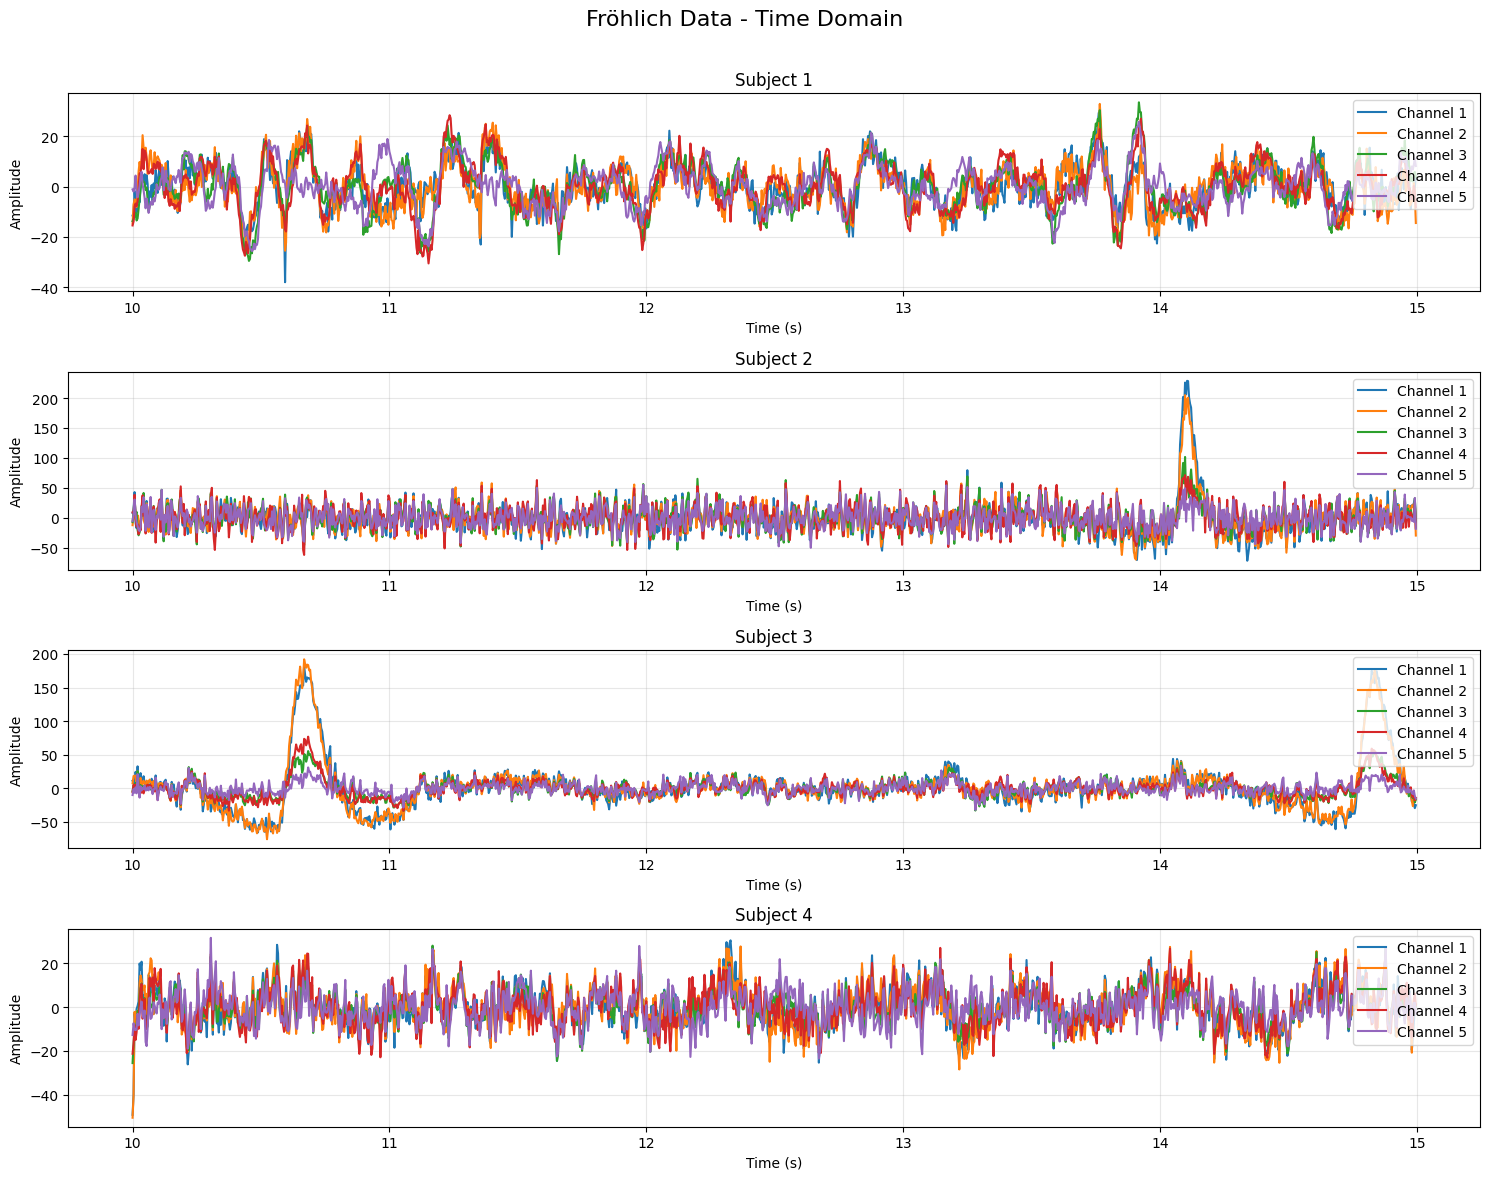

ValueError: x and y must have same first dimension, but have shapes (129,) and (1,)

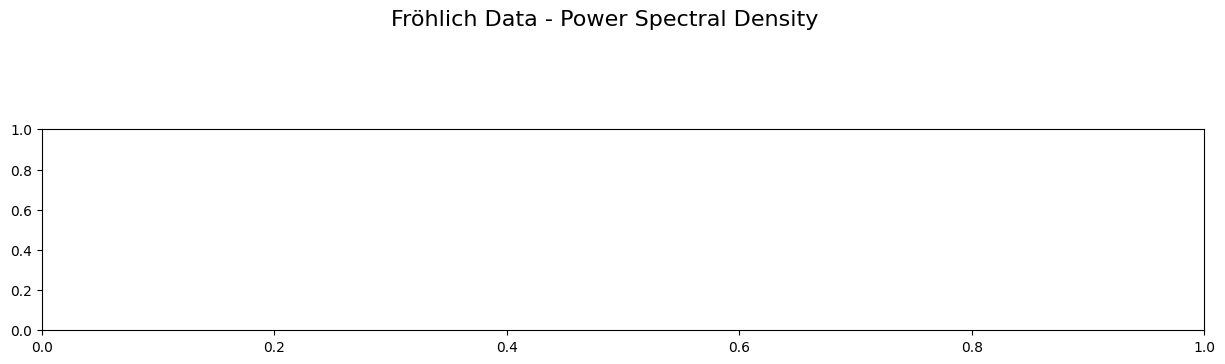

In [15]:
# Plot just the time domain representation
plot_frolich_data(frolich_data, plot_type='time', n_subjects=2)

# Plot just the PSDs
# plot_frolich_data(frolich_data, plot_type='psd')

# Plot just the spectrograms
plot_frolich_data(frolich_data, plot_type='spectrogram')

# Plot everything with custom time segment
plot_frolich_data(frolich_data, time_segment=(10, 15))  # Plot seconds 10-15